# SAT-X

SAT-X is a language for constrained optimization and decision problems over positive integers, that work with any SAT Competition standard SAT solver. Is based on Python, and is ase to learn and easy to use with all technologies asociated to this language.

## Getting Started

Let's write some simple models.

In [1]:
import satx

satx.engine(bits=10, cnf_path='tmp.cnf')

x = satx.integer()
y = satx.integer()

assert 0 < x <= 3 
assert 0 < y <= 3

assert x + y > 2

while satx.satisfy(solver='kissat'):
    print(x, y, x + y > 2)

3 3 True
2 2 True
3 2 True
2 3 True
1 2 True
1 3 True
2 1 True
3 1 True


Note that output is arbitrary, you can present the result as you want.

## A SAT-X Tutorial

### Our First Problem

#### A simple nonlinear equation

In [2]:
# install satx "pip install satx" and import satx library

import satx

# initialize the engine with apropiate bits length and declare the temporal cnf file.

satx.engine(bits=10, cnf_path='tmp.cnf')

# declare the variables

x = satx.integer()
y = satx.integer()

# make some assetios about data

assert x ** 2 + y ** 2 == 100

# call you faborite solver and solve it.

while satx.satisfy('kissat'):
    print(x, y)

0 10
10 0
6 8
8 6


#### The Sum subset Problem

This problem consist of answer, given a collection of integers if exist a subset such that this sum is equal to a predefined target.

In [3]:
import satx
import random

# declare data

bits = 10
size = 10

universe = [random.randint(1, 2 ** bits) for _ in range(size)]
target = sum(random.sample(universe, k=size // 2))

print('UNIVERSE         : {}'.format(universe))
print('TARGET           : {}'.format(target))
print(80 * '-')

# initialize the engine

satx.engine(target.bit_length(), cnf_path='tmp.cnf')

# get binary idx (int) for subsets, the subset itself and the complement (ilustrative not necesary in this example)

idx, subset, complement = satx.subsets(universe, complement=True)

# make assertions, in this case, that the subset sum the same of the target

assert sum(subset) == target

# call you faborite solver and solve it.

while satx.satisfy('kissat'):
    print('ID  | BINARY     : {} {}'.format(idx, idx.binary))
    print('SUM | SUBSET     : {} {}'.format(sum(subset), subset))
    print('SUM | COMPLEMENT : {} {}'.format(sum(complement), complement))
    print(80 * '-')

UNIVERSE         : [828, 281, 722, 753, 868, 421, 1011, 384, 834, 684]
TARGET           : 2973
--------------------------------------------------------------------------------
ID  | BINARY     : 810 [False, True, False, True, False, True, False, False, True, True]
SUM | SUBSET     : 2973 [0, 281, 0, 753, 0, 421, 0, 0, 834, 684]
SUM | COMPLEMENT : 3813 [828, 0, 722, 0, 868, 0, 1011, 384, 0, 0]
--------------------------------------------------------------------------------


# Factoring Problem (tensor implementation, different solvers)

In [4]:
%%time 

import satx

rsa = 989092942147

satx.engine(rsa.bit_length(), cnf_path='tmp.cnf')

p = satx.tensor(dimensions=(satx.bits()))
q = satx.tensor(dimensions=(satx.bits()))

assert p * q == rsa
assert p[[0]](0, 1) == 1
assert q[[0]](0, 1) == 1
assert sum(p[[i]](0, 1) for i in range(satx.bits() // 2 + 1, satx.bits())) == 0
assert sum(q[[i]](0, 1) for i in range(satx.bits() // 2, satx.bits())) == 0

if satx.satisfy(solver='kissat'):
    print(p, q)
else:
    print('Is Prime!')

1951709 506783
CPU times: user 201 ms, sys: 13 ms, total: 214 ms
Wall time: 6.87 s


In [5]:
%%time 

import satx

rsa = 989092942147

satx.engine(rsa.bit_length(), cnf_path='tmp.cnf')

p = satx.tensor(dimensions=(satx.bits()))
q = satx.tensor(dimensions=(satx.bits()))

assert p * q == rsa
assert p[[0]](0, 1) == 1
assert q[[0]](0, 1) == 1
assert sum(p[[i]](0, 1) for i in range(satx.bits() // 2 + 1, satx.bits())) == 0
assert sum(q[[i]](0, 1) for i in range(satx.bits() // 2, satx.bits())) == 0

if satx.satisfy(solver='slime'):
    print(p, q)
else:
    print('Is Prime!')

1951709 506783
CPU times: user 204 ms, sys: 11.6 ms, total: 215 ms
Wall time: 12.1 s


In [6]:
%%time 

import satx

rsa = 989092942147

satx.engine(rsa.bit_length(), cnf_path='tmp.cnf')

p = satx.tensor(dimensions=(satx.bits()))
q = satx.tensor(dimensions=(satx.bits()))

assert p * q == rsa
assert p[[0]](0, 1) == 1
assert q[[0]](0, 1) == 1
assert sum(p[[i]](0, 1) for i in range(satx.bits() // 2 + 1, satx.bits())) == 0
assert sum(q[[i]](0, 1) for i in range(satx.bits() // 2, satx.bits())) == 0

if satx.satisfy(solver='minisat'):
    print(p, q)
else:
    print('Is Prime!')

1951709 506783
CPU times: user 198 ms, sys: 11.9 ms, total: 210 ms
Wall time: 16.8 s


# PERMUTATION RECONSTRUCTION FROM DIFFERENCES

(kissat, minisat, slime)

https://arxiv.org/pdf/1410.6396.pdf

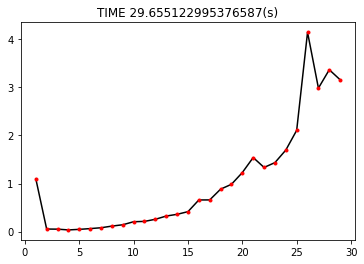

In [7]:
import time
import satx
import numpy as np
import matplotlib.pyplot as plt

def gen_instance(n):
    import random
    y = list(range(1, n + 1))
    random.shuffle(y)
    return [abs(y[i + 1] - y[i]) for i in range(n - 1)]

start = time.time()

times = []
sizes = []

for n in range(1, 30):
    diffs = gen_instance(n)
    
    ini = time.time()
    
    satx.engine(n.bit_length() + 1, cnf_path='tmp.cnf')
    
    x = satx.vector(size=n)
    
    satx.all_different(x)
    
    satx.apply_single(x, lambda a: 1 <= a <= n)
    
    for i in range(n - 1):
        assert satx.index(i, diffs) == satx.one_of([x[i + 1] - x[i], x[i] - x[i + 1]])
    
    if satx.satisfy('kissat'):
        end = time.time() - ini
        xx = [abs(x[i + 1] - x[i]) for i in range(n - 1)]
        if xx == diffs:
            sizes.append(n)
            times.append(end)
        else:
            raise Exception('Error!')
    else:
        raise Exception('Error!')
    
end = time.time() - start
plt.title('TIME {}(s)'.format(end))
plt.plot(sizes, times, 'k-')
plt.plot(sizes, times, 'r.')
plt.show()
plt.close()

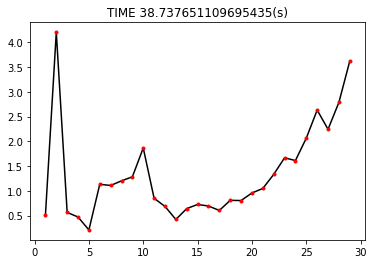

In [8]:
import time
import satx
import numpy as np
import matplotlib.pyplot as plt

def gen_instance(n):
    import random
    y = list(range(1, n + 1))
    random.shuffle(y)
    return [abs(y[i + 1] - y[i]) for i in range(n - 1)]

start = time.time()

times = []
sizes = []

for n in range(1, 30):
    diffs = gen_instance(n)
    
    ini = time.time()
    
    satx.engine(n.bit_length() + 1, cnf_path='tmp.cnf')
    
    x = satx.vector(size=n)
    
    satx.all_different(x)
    
    satx.apply_single(x, lambda a: 1 <= a <= n)
    
    for i in range(n - 1):
        assert satx.index(i, diffs) == satx.one_of([x[i + 1] - x[i], x[i] - x[i + 1]])
    
    if satx.satisfy('minisat'):
        end = time.time() - ini
        xx = [abs(x[i + 1] - x[i]) for i in range(n - 1)]
        if xx == diffs:
            sizes.append(n)
            times.append(end)
        else:
            raise Exception('Error!')
    else:
        raise Exception('Error!')
    
end = time.time() - start
plt.title('TIME {}(s)'.format(end))
plt.plot(sizes, times, 'k-')
plt.plot(sizes, times, 'r.')
plt.show()
plt.close()

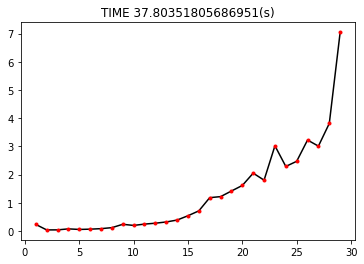

In [9]:
import time
import satx
import numpy as np
import matplotlib.pyplot as plt

def gen_instance(n):
    import random
    y = list(range(1, n + 1))
    random.shuffle(y)
    return [abs(y[i + 1] - y[i]) for i in range(n - 1)]

start = time.time()

times = []
sizes = []

for n in range(1, 30):
    diffs = gen_instance(n)
    
    ini = time.time()
    
    satx.engine(n.bit_length() + 1, cnf_path='tmp.cnf')
    
    x = satx.vector(size=n)
    
    satx.all_different(x)
    
    satx.apply_single(x, lambda a: 1 <= a <= n)
    
    for i in range(n - 1):
        assert satx.index(i, diffs) == satx.one_of([x[i + 1] - x[i], x[i] - x[i + 1]])
    
    if satx.satisfy('slime'):
        end = time.time() - ini
        xx = [abs(x[i + 1] - x[i]) for i in range(n - 1)]
        if xx == diffs:
            sizes.append(n)
            times.append(end)
        else:
            raise Exception('Error!')
    else:
        raise Exception('Error!')
    
end = time.time() - start
plt.title('TIME {}(s)'.format(end))
plt.plot(sizes, times, 'k-')
plt.plot(sizes, times, 'r.')
plt.show()
plt.close()

# BIN PACKING PROBLEM

In the bin packing problem, items of different volumes must be packed into a finite number of bins or containers each of a fixed given volume in a way that minimizes the number of bins used. In computational complexity theory, it is a combinatorial NP-hard problem. The decision problem (deciding if items will fit into a specified number of bins) is NP-complete.

https://en.wikipedia.org/wiki/Bin_packing_problem

In [10]:
%%time 

import satx
import numpy as np

capacity = 100
size = 100
elements = sorted([np.random.randint(1, capacity // 2 - 1) for _ in range(size)], reverse=True)

print(capacity)
print(elements)

bins = int(np.ceil(sum(elements) / capacity))

while True:
    satx.engine(bits=capacity.bit_length() + 1, cnf_path='tmp.cnf')
    
    slots = satx.vector(bits=len(elements), size=bins)
    
    for i in range(len(elements)):
        assert sum(satx.switch(slot, i) for slot in slots) == 1
        
    for slot in slots:
        assert sum(satx.switch(slot, i) * elements[i] for i in range(len(elements))) <= capacity
        
    if satx.satisfy('kissat'):
        print('Solution for {} bins...'.format(bins))
        for slot in slots:
            print(''.join(['_' if boolean else '#' for boolean in slot.binary]))
        for slot in slots:
            sub = [item for i, item in enumerate(elements) if not slot.binary[i]]
            print(sum(sub), sub)    
        break
    else:
        print('No solution for {} bins...'.format(bins))
        bins += 1

100
[48, 48, 48, 47, 47, 46, 46, 46, 45, 44, 44, 43, 43, 42, 42, 42, 42, 41, 41, 41, 40, 40, 39, 39, 38, 38, 37, 37, 36, 36, 36, 34, 34, 34, 32, 32, 32, 31, 31, 31, 31, 31, 30, 29, 28, 28, 28, 28, 27, 27, 27, 26, 26, 26, 26, 26, 25, 25, 25, 25, 22, 22, 20, 19, 19, 18, 17, 17, 17, 16, 16, 15, 15, 15, 15, 15, 14, 14, 14, 14, 11, 10, 9, 8, 7, 7, 6, 6, 5, 5, 5, 4, 4, 4, 3, 3, 2, 2, 2, 1]
Solution for 26 bins...
__________#_______________________________#______________#__________________________________________
__#_#___________________________________________________________________________________#___________
______#________#__________________________________________________________________#_____________#___
________________________________##_________#__________________________________________________#_____
___________________________#_________#______#_______________________________________________________
___#______________________#______________________________________________#__________